# SG13G2 Device Model Verification

This notebook provides a comprehensive guide to setting up the environment for verifying the SG13G2 devices models.

## 1. Setup

> Before running this notebook, make sure you have completed the installation steps described in the [Prerequisites section](../README.md#prerequisites).  

This includes:  
- Building the OSDI models (see [Verilog-A README](../../../verilog-a/README.md))  
- Creating and activating a Python virtual environment  
- Installing all required dependencies from `requirements.txt`  

Once these steps are done, you can proceed with running this notebook.


## 2. Explore Data & Errors

This section focuses on running device tests, visualizing the results, and interpreting any failures from the verification process.

*   Run Device Tests (Interactive Widget)
*   Explore Data & Errors (Plotting Results)
*   Interpreting pytest assertion failures

In [1]:
import os
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import ScalarFormatter

from ipywidgets import (
    BoundedIntText,
    Button,
    Dropdown,
    HBox,
    HTML,
    Label,
    Output,
    VBox,
)
from IPython.display import display

import sys
from pathlib import Path

# Go up one level from workflow_notebooks/ → devices/
repo_root = Path.cwd().parent
sys.path.append(str(repo_root))

from models_verifier.constants import CASES
from models_verifier.models_verifier import MdmVerifier

In [2]:
TESTS_DIR = Path(os.getcwd()).parent
print(f"Current working directory: {TESTS_DIR}")

Current working directory: /home/marwan/Desktop/IHP-Open-PDK/ihp-sg13g2/libs.tech/ngspice/testing/devices


## Environment Setup

This section sets up the necessary environment variables for the IHP-Open-PDK testing framework.

In [3]:
os.environ["PYTHONPATH"] = str(TESTS_DIR)
%cd -q $TESTS_DIR

/home/marwan/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
CASE_MAP = {label: rel for label, rel in CASES}
print("Available device tests:")
for label in CASE_MAP:
    print(f" - {label}")

Available device tests:
 - nmos_lv
 - pmos_lv
 - nmos_hv
 - pmos_hv
 - pnp_mpa
 - npn13g2
 - npn13g2l
 - npn13g2v


In [ ]:
def load_sim_merged_dict(verifier: MdmVerifier) -> Dict[str, pd.DataFrame]:
    """Return dict[setup_type] -> DataFrame. Falls back to filename stem."""
    sim_dir = (verifier.output_dir / "combined_results").resolve()
    out: Dict[str, pd.DataFrame] = {}
    for p in sorted(sim_dir.glob("*.csv")):
        df = pd.read_csv(p)
        setup = (
            str(df.get("master_setup_type", pd.Series([p.stem])).iloc[0])
            if not df.empty else p.stem
        )
        df["source_csv"] = p.name
        out[setup] = df
    return out

In [ ]:
def run_one_device(label: str):
    cfg_path = TESTS_DIR / CASE_MAP[label]
    if not cfg_path.exists():
        print(f"[ERROR] Config YAML not found:\n  {cfg_path}")
        return

    global verifier
    verifier = MdmVerifier(cfg_path)

    verifier.run_verification()
    summary_csv = verifier.output_dir / "summary.csv"
    if summary_csv.exists():
        try:
            df_summary = pd.read_csv(summary_csv)
            if not df_summary.empty:
                display(df_summary)
        except Exception as e:
            print(f"[WARN] Could not preview summary.csv: {e}")

device_dropdown = Dropdown(options=list(CASE_MAP.keys()))
run_btn = Button(description="Run test", button_style="primary")
out = Output()

def _run_clicked(_):
    with out:
        out.clear_output()
        run_one_device(device_dropdown.value)

run_btn.on_click(_run_clicked)

display(VBox([
    Label("Select a device to run the test:"),
    device_dropdown,
    run_btn,
    out
]))

In [7]:
SIM_MERGED_BY_SETUP = load_sim_merged_dict(verifier)

In [ ]:
def _style_axes(ax: plt.Axes, sweep_var: str, output_var: str) -> None:
    ax.set_xlabel(str(sweep_var))
    ax.set_ylabel(str(output_var))
    ax.grid(True, alpha=0.25)
    sf = ScalarFormatter(useMathText=True)
    sf.set_powerlimits((-3, 3))
    ax.yaxis.set_major_formatter(sf)

def _split_sim_cols(df_block: pd.DataFrame, out_first: str) -> Tuple[List[str], Optional[str], List[str]]:
    """
    Return (sim_cols, typ_col, others).
    sim_cols: all columns starting with f"{out_first}_sim_"
    typ_col: one with suffix in {'typ','tt','typical'} if present, else None
    others: sim_cols excluding typ_col
    """
    prefix = f"{out_first}_sim_"
    sim_cols = [c for c in df_block.columns if c.startswith(prefix)]
    if not sim_cols:
        return [], None, []

    def is_typ(col: str) -> bool:
        suf = col.split("_")[-1].lower()
        return suf in {"typ", "tt", "typical"}

    typ_candidates = [c for c in sim_cols if is_typ(c)]
    typ_col = typ_candidates[0] if typ_candidates else None
    others = [c for c in sim_cols if c != typ_col]
    return sim_cols, typ_col, others

def _outside_mask(y: np.ndarray, lo: np.ndarray, hi: np.ndarray) -> np.ndarray:
    return (y < lo) | (y > hi)

def _parse_block_outputs(block: pd.DataFrame) -> List[str]:
    """Parse block['output_vars'] (comma-separated string) -> list of names."""
    if "output_vars" not in block.columns or pd.isna(block["output_vars"].iloc[0]):
        return []
    raw = str(block["output_vars"].iloc[0])
    return [s.strip() for s in raw.split(",") if s.strip()]
def _device_param_columns_for_titles(device_type_hint: str) -> list[str]:
    m = {
          'mos':    ['w','l','ad','as','pd','ps','nf','m'],
          'pnpmpa': ['a','p'],
          'hbt':    ['ve','vs','l','w','m','nx'],
      }
    dt = (device_type_hint or "").lower()
    if dt in m:
        return m[dt]
    for k, v in m.items():
        if k in dt:
            return v
    return []

def _format_panel_title(block: pd.DataFrame, out_name: str, device_type_hint: str) -> str:
    cols = _device_param_columns_for_titles(device_type_hint)
    row = block.iloc[0]
    parts = []
    for c in cols:
        if c in block.columns and pd.notna(row.get(c, np.nan)):
            val = row[c]
            if isinstance(val, float):
                val = f"{val:.4g}"
            parts.append(f"{c}={val}")

    t_str = None
    if "temp" in block.columns and pd.notna(row.get("temp", np.nan)):
        t_str = f"T={row['temp']}°C"

    src_str = None
    if "input_data" in block.columns and pd.notna(row.get("input_data", np.nan)):
        src_str = str(row["input_data"])

    left_bits = [out_name.upper()]
    if src_str:
        left_bits.append(f"[{src_str}]")
    left = " — ".join(left_bits)

    right_bits = [t_str] if t_str else []
    if parts:
        right_bits.append(", ".join(parts))
    right = " — " + " | ".join(right_bits) if right_bits else ""

    return left + right



In [18]:
def plot_blocks_comparison(
    df: pd.DataFrame,
    device_type_hint: str = "mos",
    block_ids: Optional[List[str]] = None,
    figsize: Tuple[float, float] = (10, 6),
    ncols: int = 3,
    max_blocks: Optional[int] = 20,
) -> Tuple[plt.Figure, List[plt.Axes]]:
    """
    Create a grid where EACH (block_id, output_var) gets its own panel.

    Expected df schema (wide format):
      Required columns:
        - block_id
        - sweep_var: column name (string) indicating which column is X
        - output_vars: comma-separated string of output names (e.g., "id, vout, gm")
      Optional columns:
        - temp, w, l
      Data columns:
        - For each output "y": measured column "y_meas" (optional)
        - Simulation columns "y_sim_<corner>" (e.g., y_sim_tt, y_sim_ss, ...)

    Behavior:
      - Detect sim corners for each output (prefix "y_sim_")
      - If a typical corner ("typ"/"tt"/"typical") exists, draw it as dashed baseline
      - Shade min–max band across non-typ corners
      - Plot measured series if present and mark points outside band
    """
    COLORS = {
        "range_fill": "#ccc2c2",
        "typ":        "#2F2F2F",
        "sim_alt":    "#9A9A9A",
        "meas":       "#1f77b4",
        "outside":    "#d62728",
    }

    if block_ids is None:
        block_ids = list(pd.unique(df["block_id"]))
    if max_blocks is not None:
        block_ids = block_ids[:max_blocks]

    # Build panel list: all outputs for each block
    panels: List[Tuple[str, str]] = []
    for bid in block_ids:
        block = df[df["block_id"] == bid]
        if block.empty:
            continue
        for out_name in _parse_block_outputs(block):
            panels.append((bid, out_name))

    # No panels -> empty fig
    if not panels:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax.text(0.5, 0.5, "No panels to plot.", ha="center", va="center", transform=ax.transAxes)
        ax.set_axis_off()
        plt.tight_layout()
        return fig, [ax]

    # Make grid
    nrows = int(np.ceil(len(panels) / ncols))
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(figsize[0] * ncols, figsize[1] * nrows),
        squeeze=False
    )
    axes_flat = axes.flatten()

    for i, (bid, out_name) in enumerate(panels):
        ax = axes_flat[i]
        block = df[df["block_id"] == bid].copy()
        if block.empty:
            ax.text(0.5, 0.5, f"No data for\n{bid}", ha="center", va="center", transform=ax.transAxes)
            ax.set_axis_off()
            continue

        sweep_var = str(block["sweep_var"].iloc[0])
        block = block.sort_values(sweep_var)
        x = block[sweep_var].to_numpy()

        meas_col = f"{out_name}_meas"
        sim_cols, typ_col, others = _split_sim_cols(block, out_name)

        # Envelope from non-typical corners
        y_lo = y_hi = None
        if others:
            sims = block[others].to_numpy(dtype=float)
            y_lo = np.min(sims, axis=1)
            y_hi = np.max(sims, axis=1)
            ax.fill_between(x, y_lo, y_hi, alpha=0.75, color=COLORS["range_fill"], label="Simulation Range")

        # Typical baseline or all sims if no typ
        if typ_col is not None:
            ax.plot(x, block[typ_col].to_numpy(dtype=float), "--", linewidth=1.8, color=COLORS["typ"],
                    label=typ_col.replace(f"{out_name}_sim_", "").upper())
        else:
            for c in sim_cols:
                ax.plot(x, block[c].to_numpy(dtype=float), "--", linewidth=1.2, alpha=0.7, color=COLORS["sim_alt"],
                        label=c.replace(f"{out_name}_sim_", "").upper())

        # Measured
        if meas_col in block.columns:
            y_meas = block[meas_col].to_numpy(dtype=float)
            ax.plot(x, y_meas, "-o", linewidth=1.9, markersize=3.5, color=COLORS["meas"], label="Measured")
            if (y_lo is not None) and (y_hi is not None):
                mask = _outside_mask(y_meas, y_lo, y_hi)
                if np.any(mask):
                    ax.scatter(x[mask], y_meas[mask], marker="x", s=64, linewidths=2.2,
                               color=COLORS["outside"], label="Measured Outside Range", zorder=3)

        # Titles and styling
        ax.set_title(_format_panel_title(block, out_name, device_type_hint), fontsize=10)
        _style_axes(ax, sweep_var, out_name)

        # De-duplicate legend entries
        handles, labels = ax.get_legend_handles_labels()
        seen, H, L = set(), [], []
        for h, lab in zip(handles, labels):
            if lab not in seen:
                seen.add(lab); H.append(h); L.append(lab)
        if H:
            ax.legend(H, L, fontsize=8, frameon=False, loc="best")

    # Hide unused axes
    for j in range(len(panels), len(axes_flat)):
        axes_flat[j].set_visible(False)

    plt.tight_layout()
    return fig, list(axes_flat[:len(panels)])


In [19]:
def plot_csv_type(setup_type: str, panels: int = 20, ncols: int = 4):
    """
    Plot up to `panels` (block_id, output) panels from a single sim_merged CSV type.
    Requires SIM_MERGED_BY_SETUP (dict[str, DataFrame]) from the verification run.
    """
    if "SIM_MERGED_BY_SETUP" not in globals() or setup_type not in SIM_MERGED_BY_SETUP:
        print(f"[ERROR] '{setup_type}' not loaded. Run a device first.")
        return

    df = SIM_MERGED_BY_SETUP[setup_type]
    if df.empty:
        print(f"[WARN] '{setup_type}' dataframe is empty.")
        return

    block_ids = list(pd.unique(df["block_id"]))[:panels]
    if not block_ids:
        print(f"[WARN] No block_id in '{setup_type}'.")
        return

    fig, axes = plot_blocks_comparison(
        df=df,
        block_ids=block_ids,
        ncols=ncols,
        max_blocks=panels,
        device_type_hint=verifier.device_type,
    )
    display(fig)
    return fig, axes



=== fg_vcb0 ===


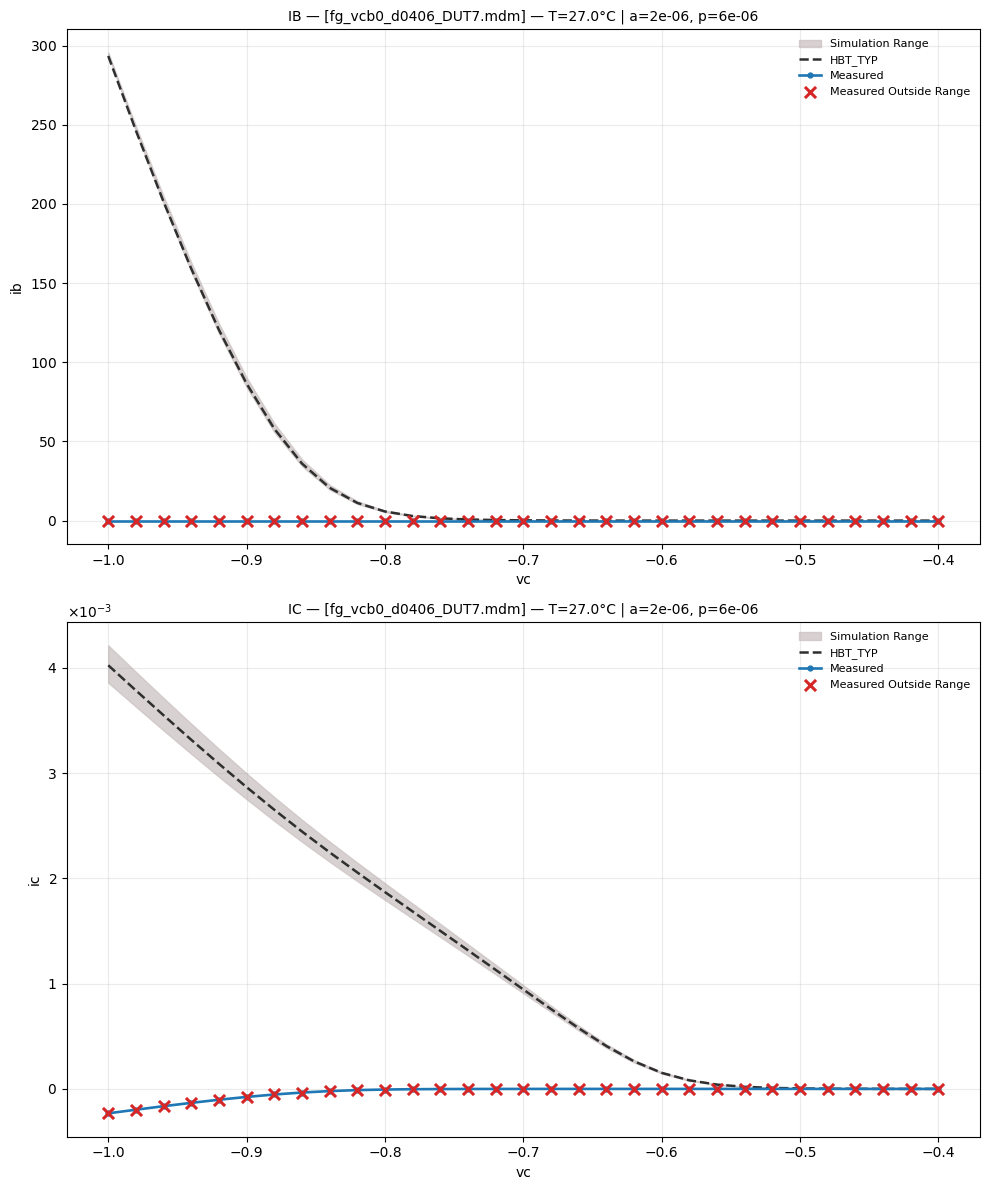


=== fg_vce ===


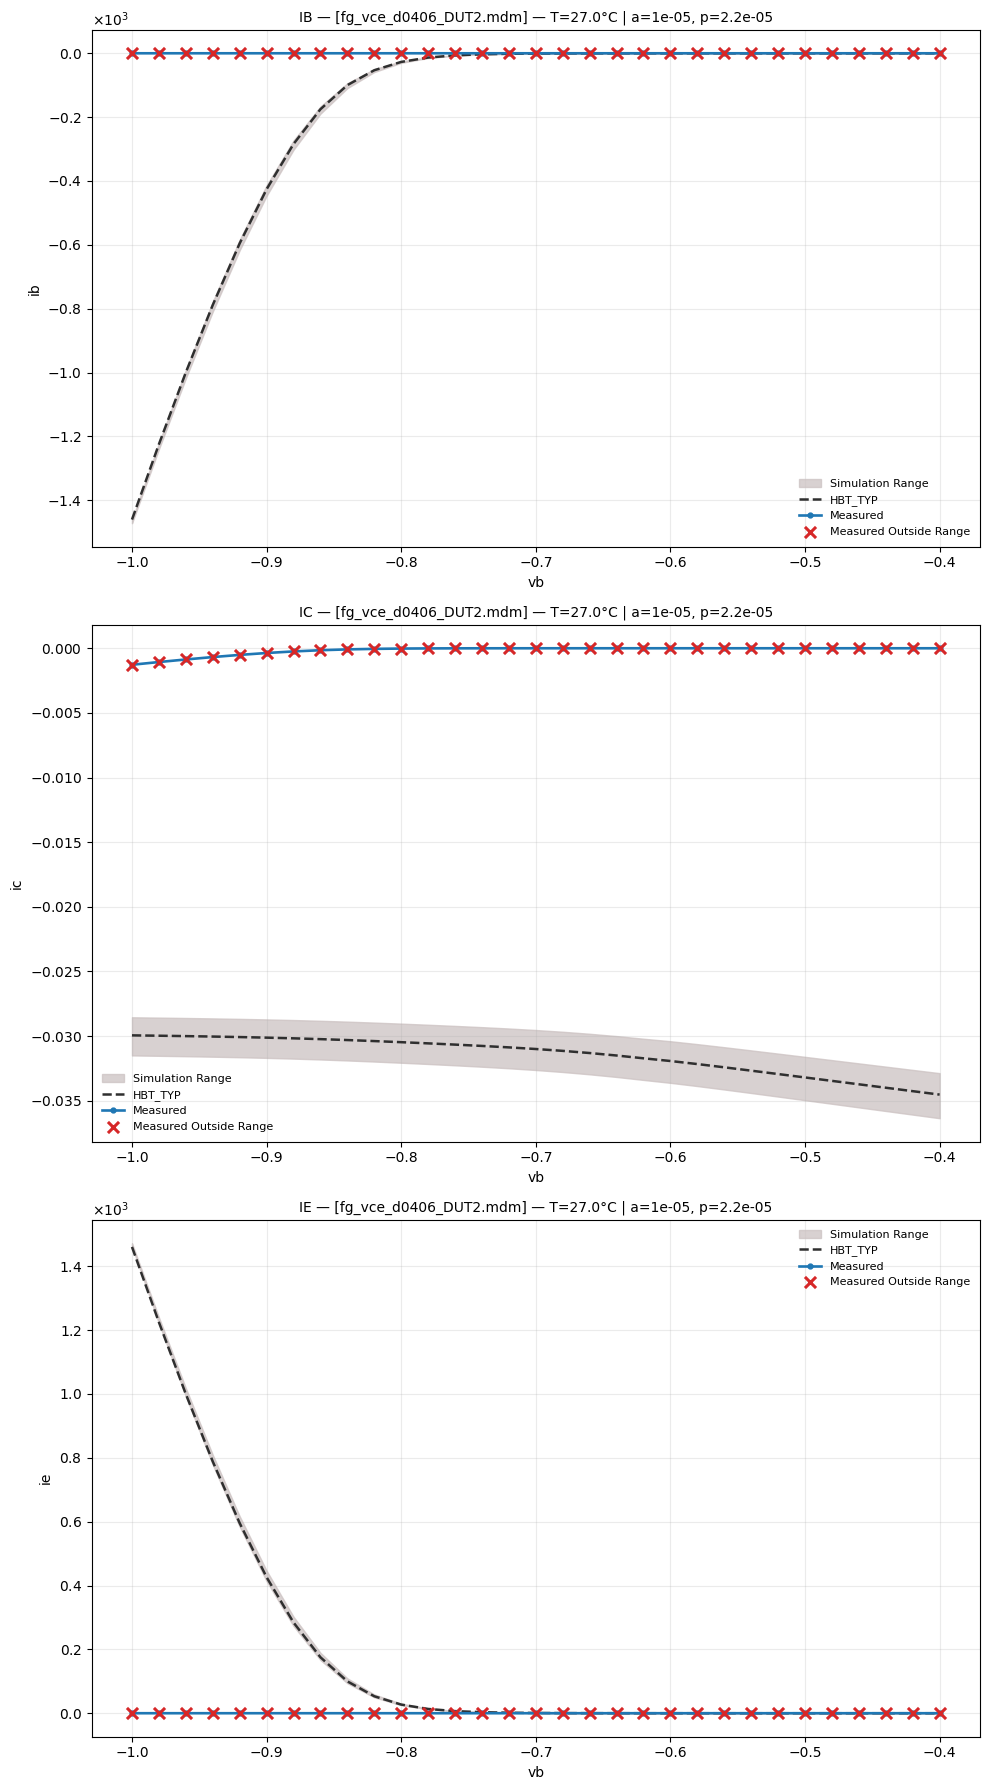


=== fo_ib ===


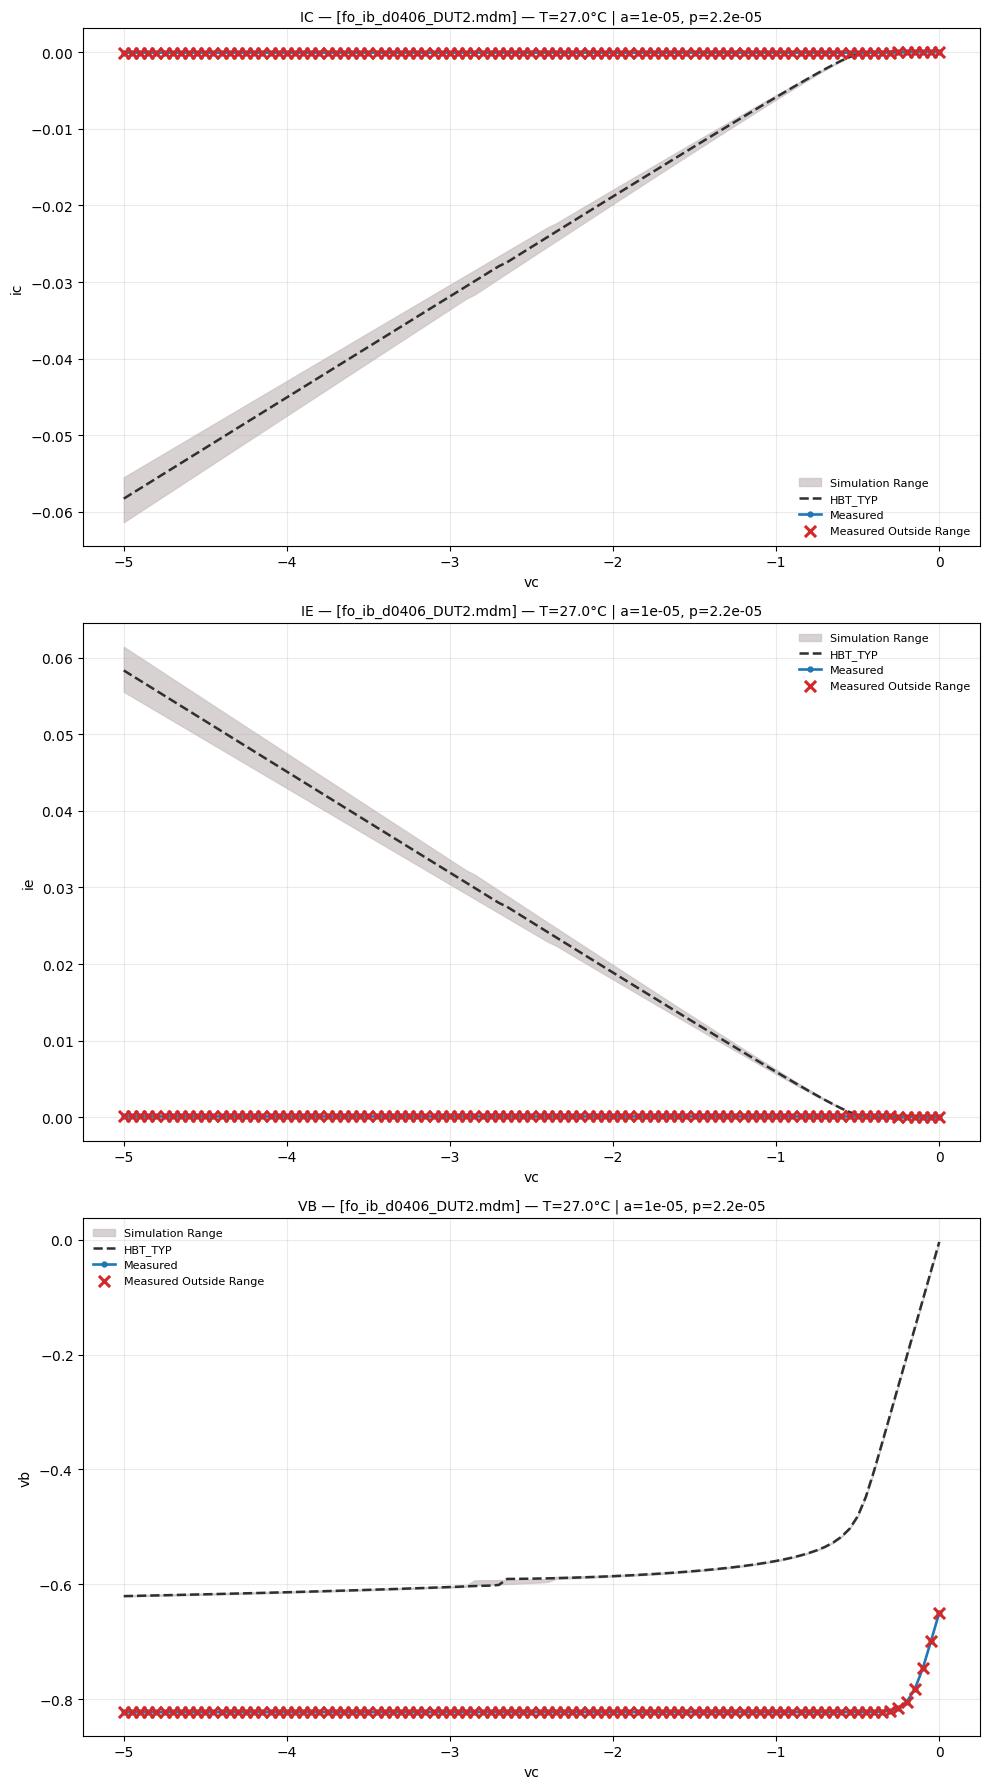


=== fo_vb ===


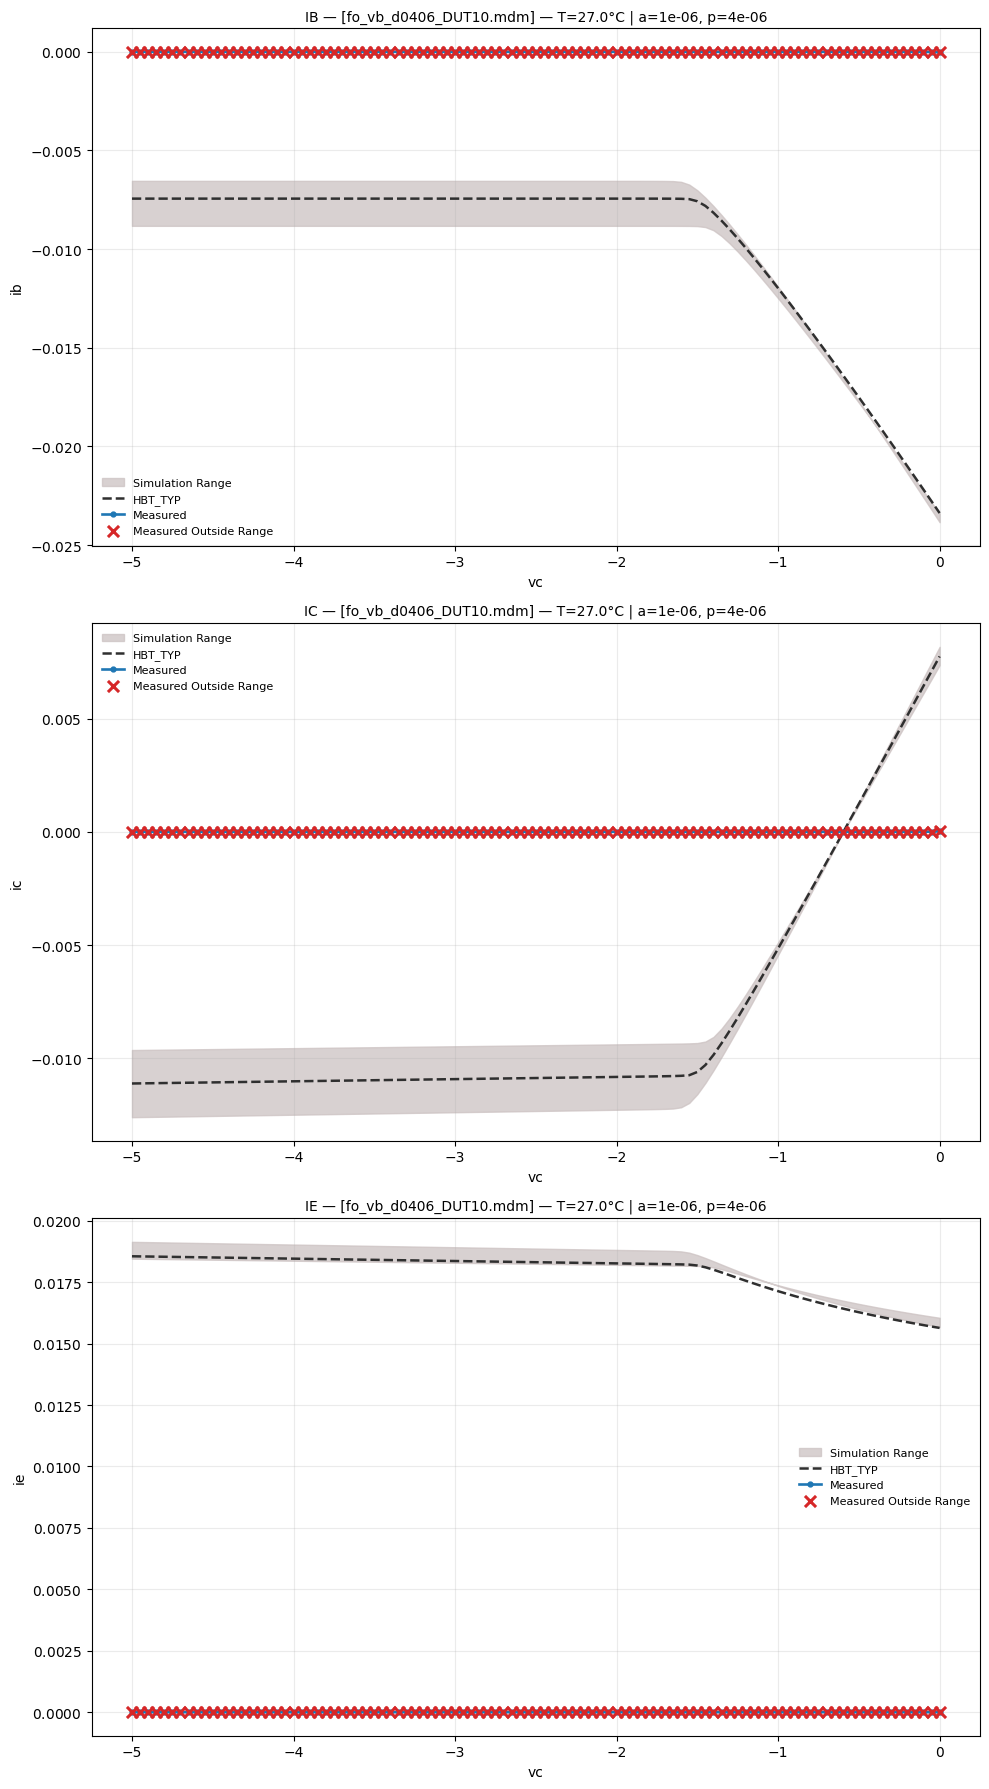


=== rg_d0406 ===


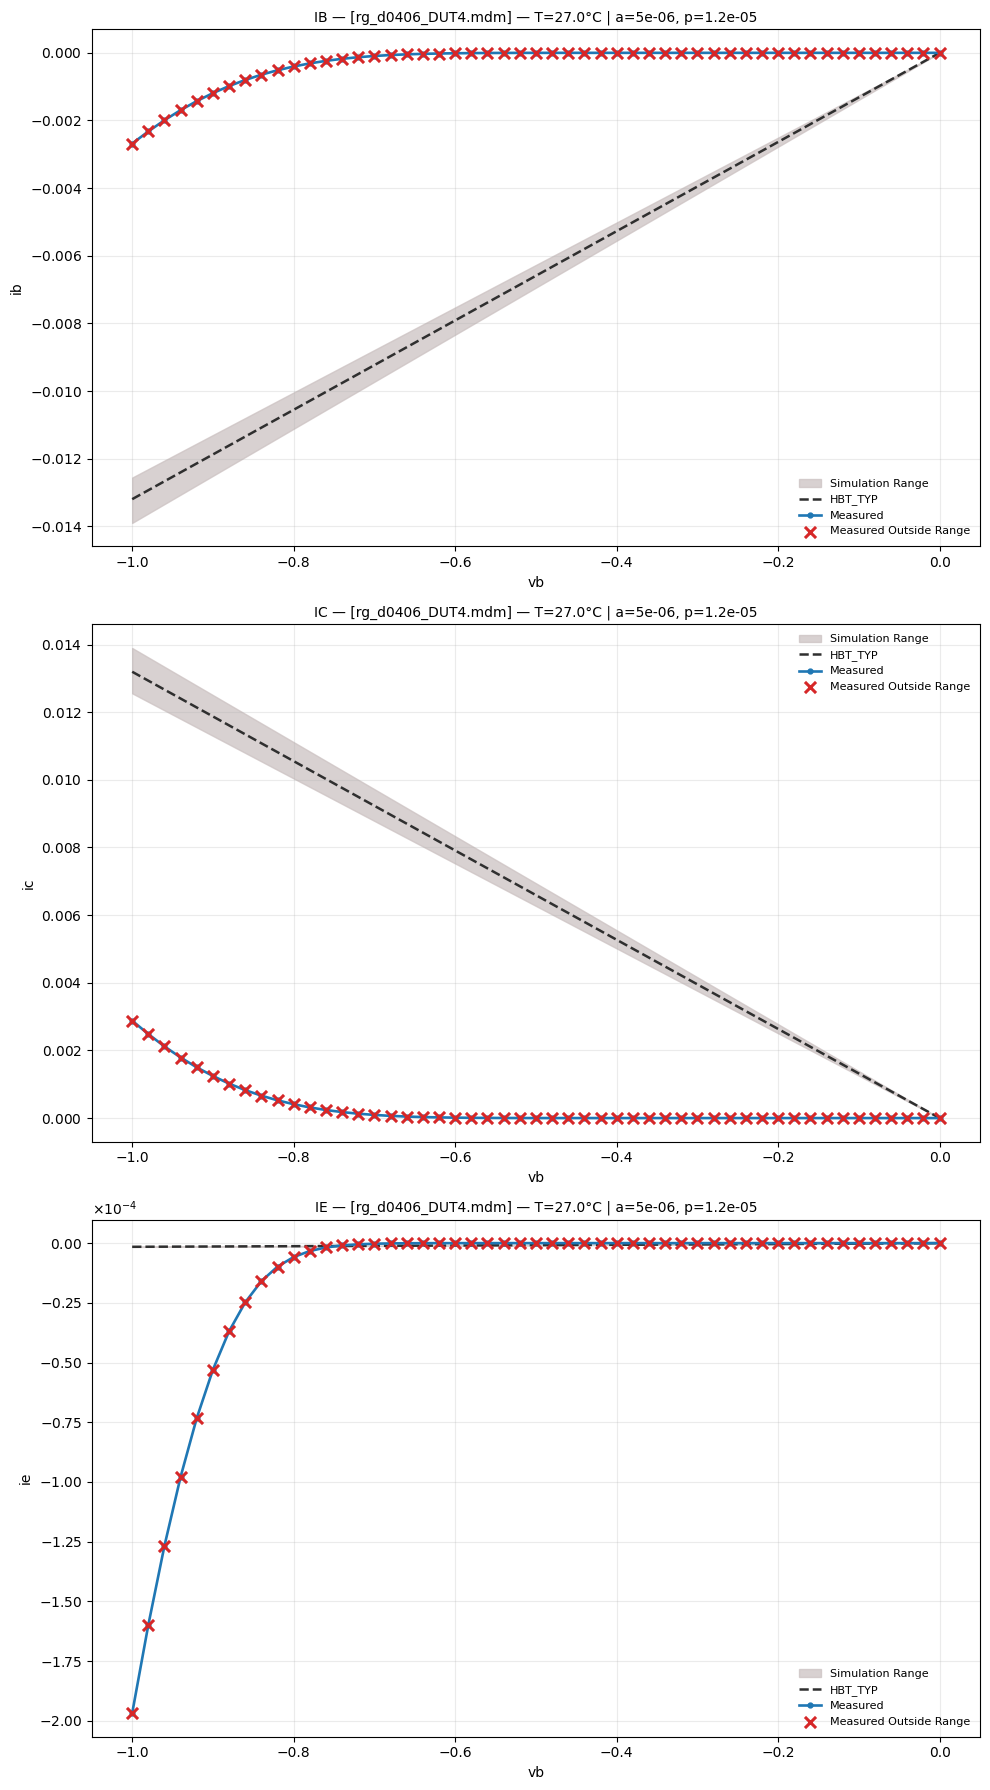


=== ro_vb ===


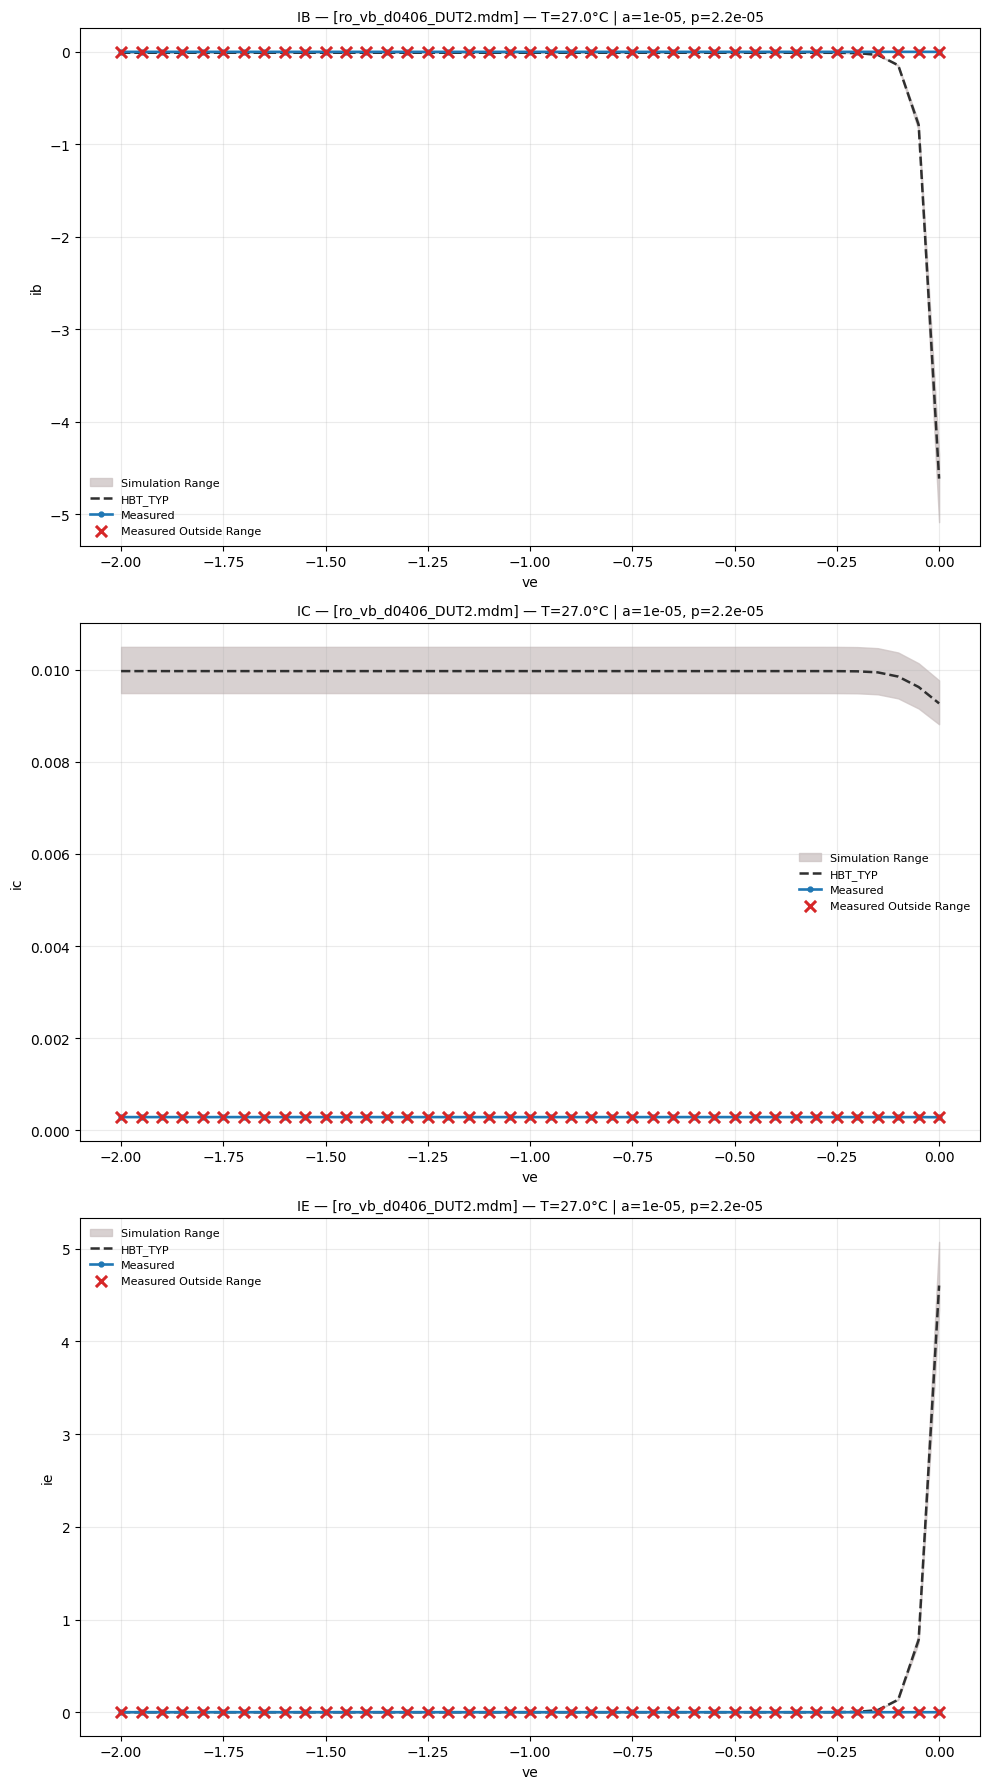

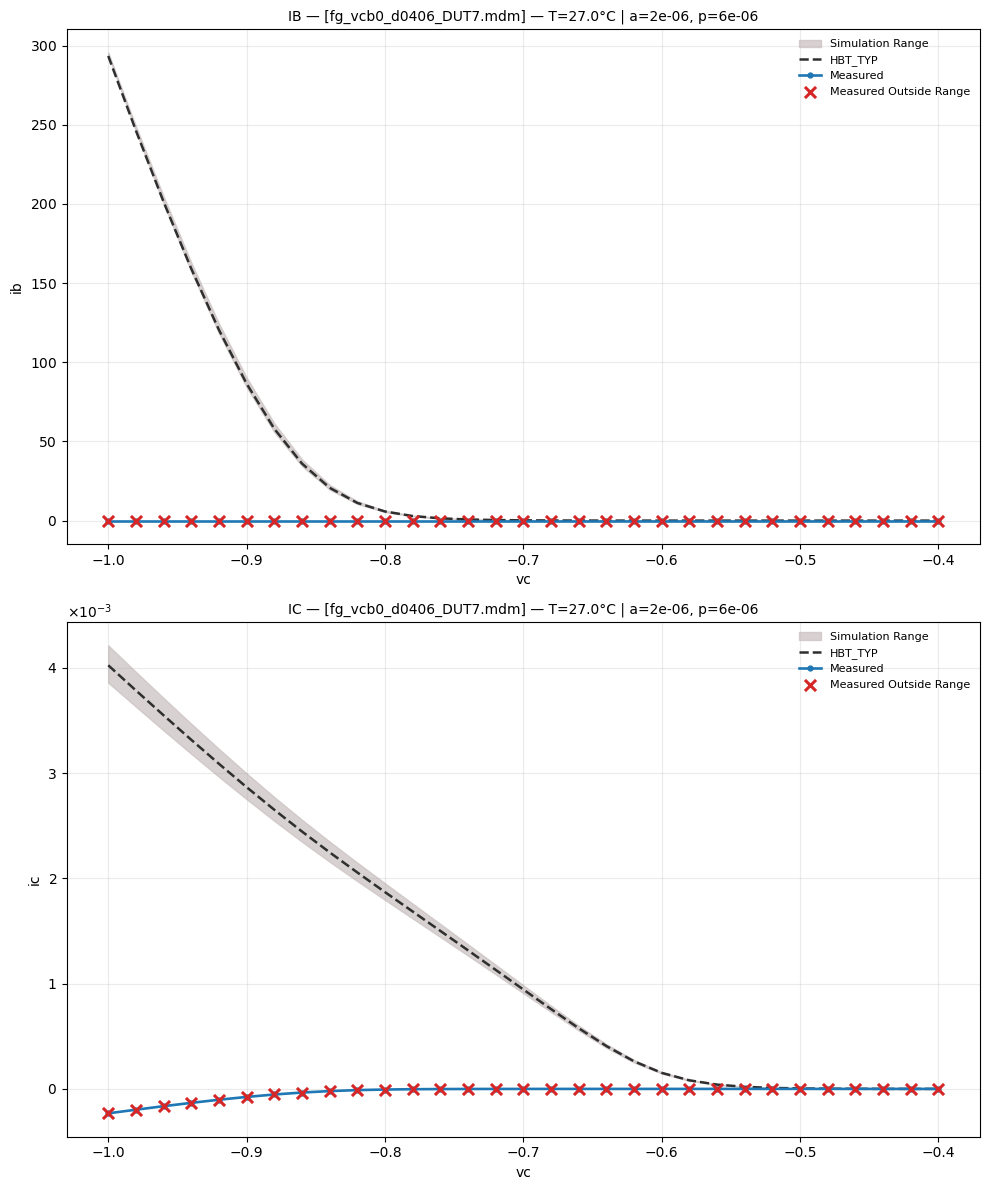

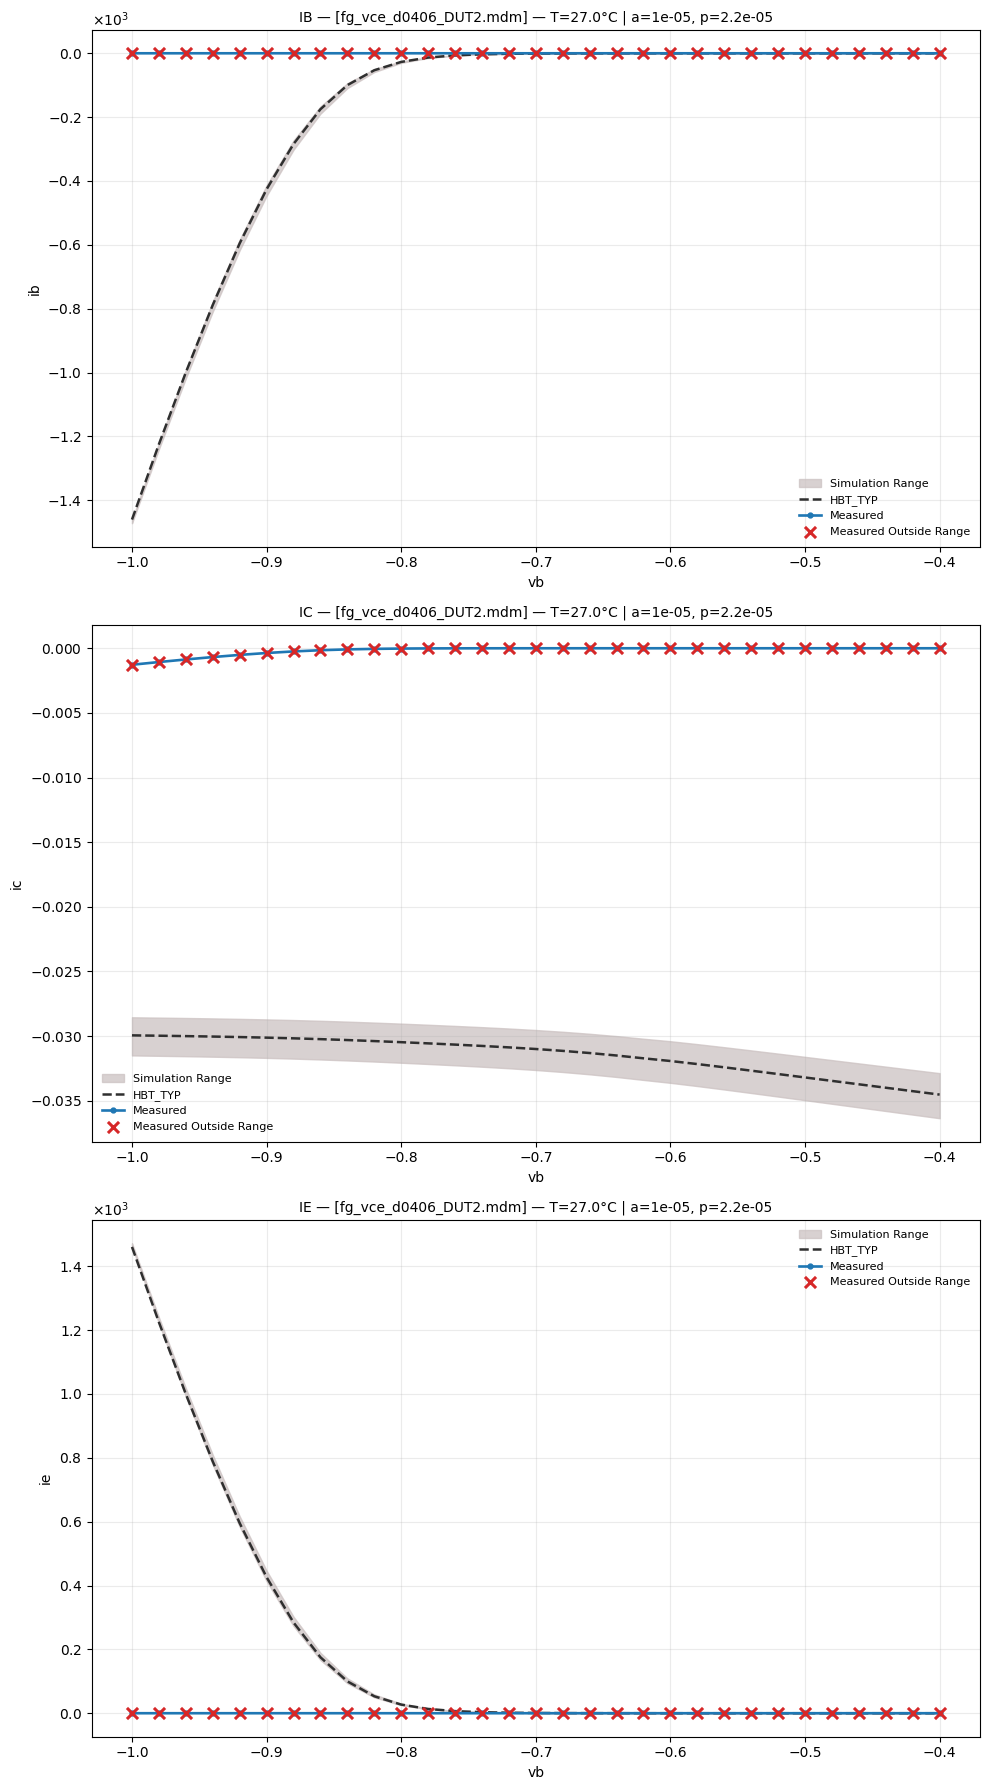

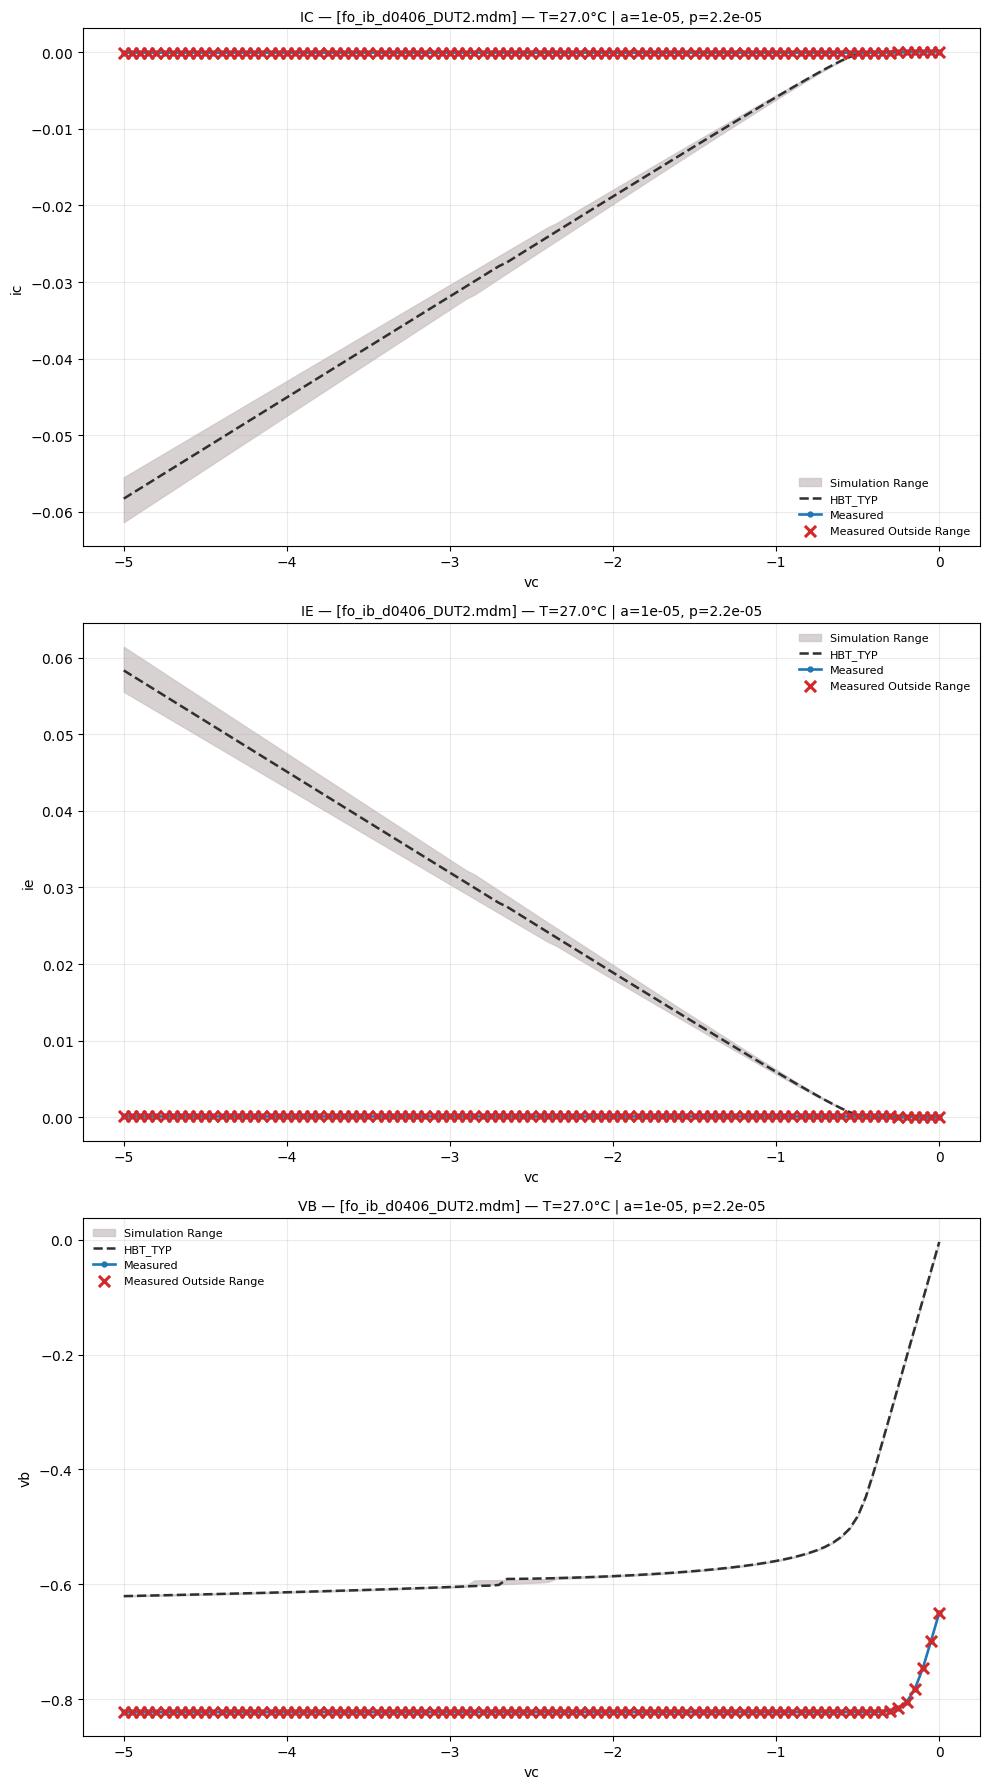

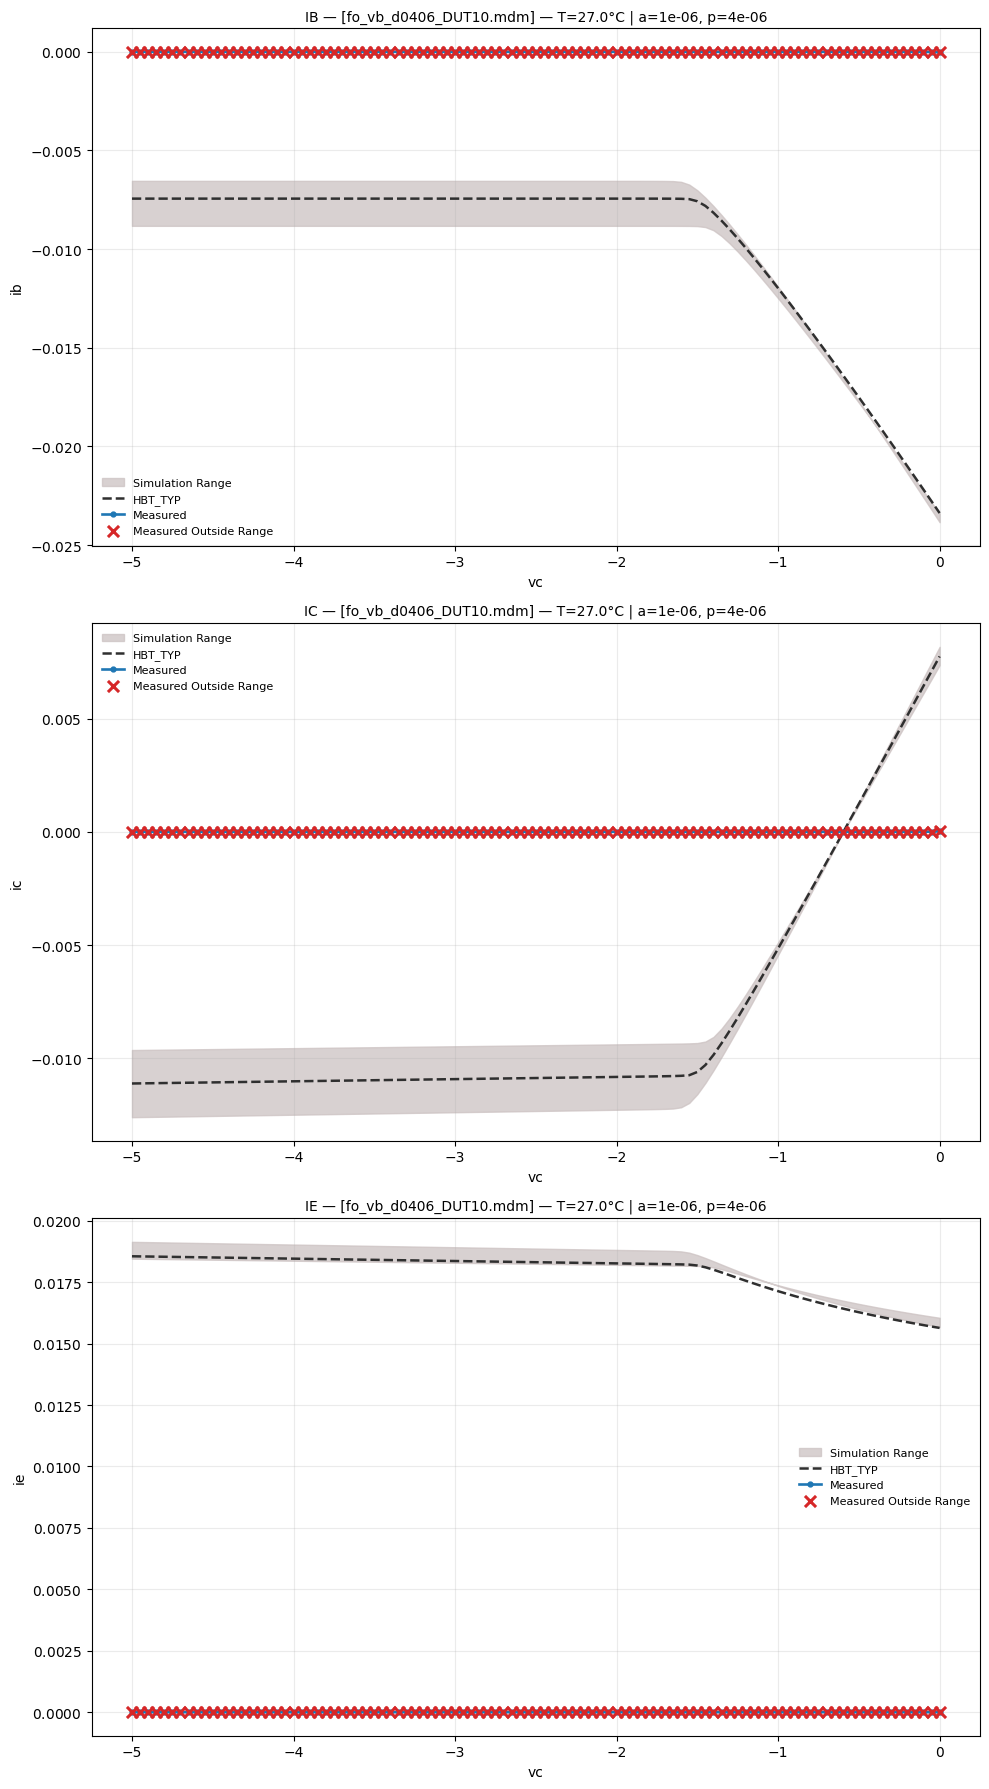

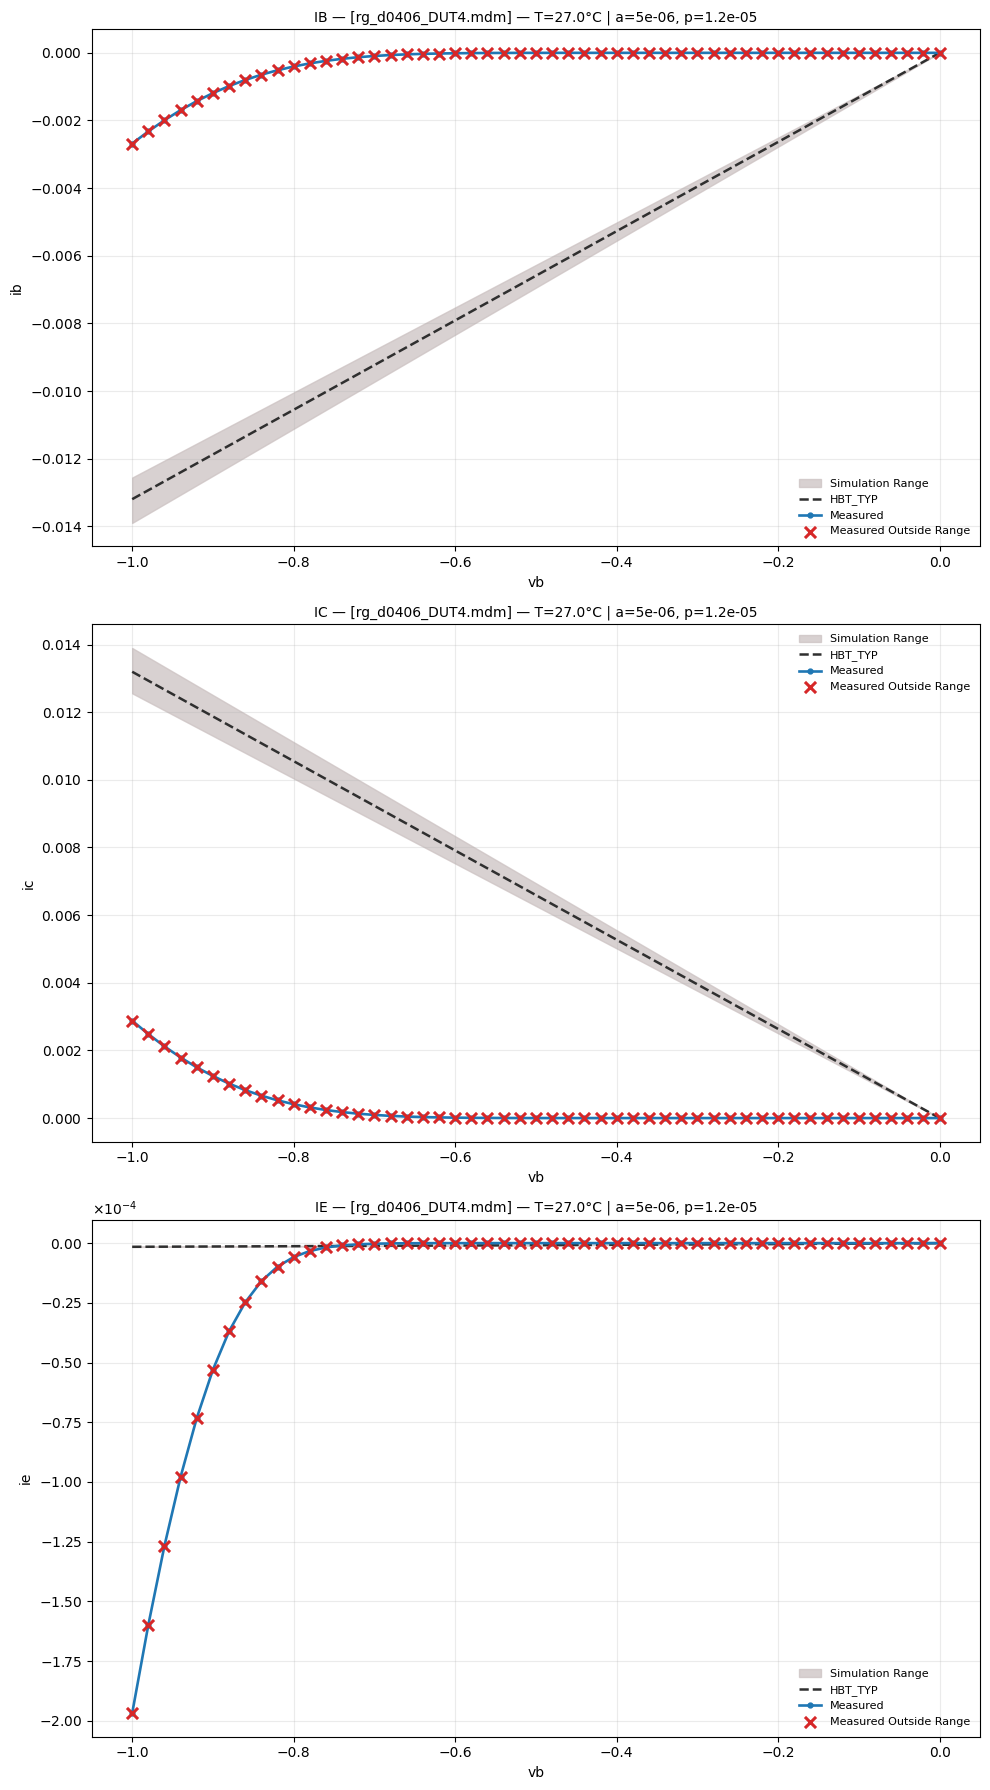

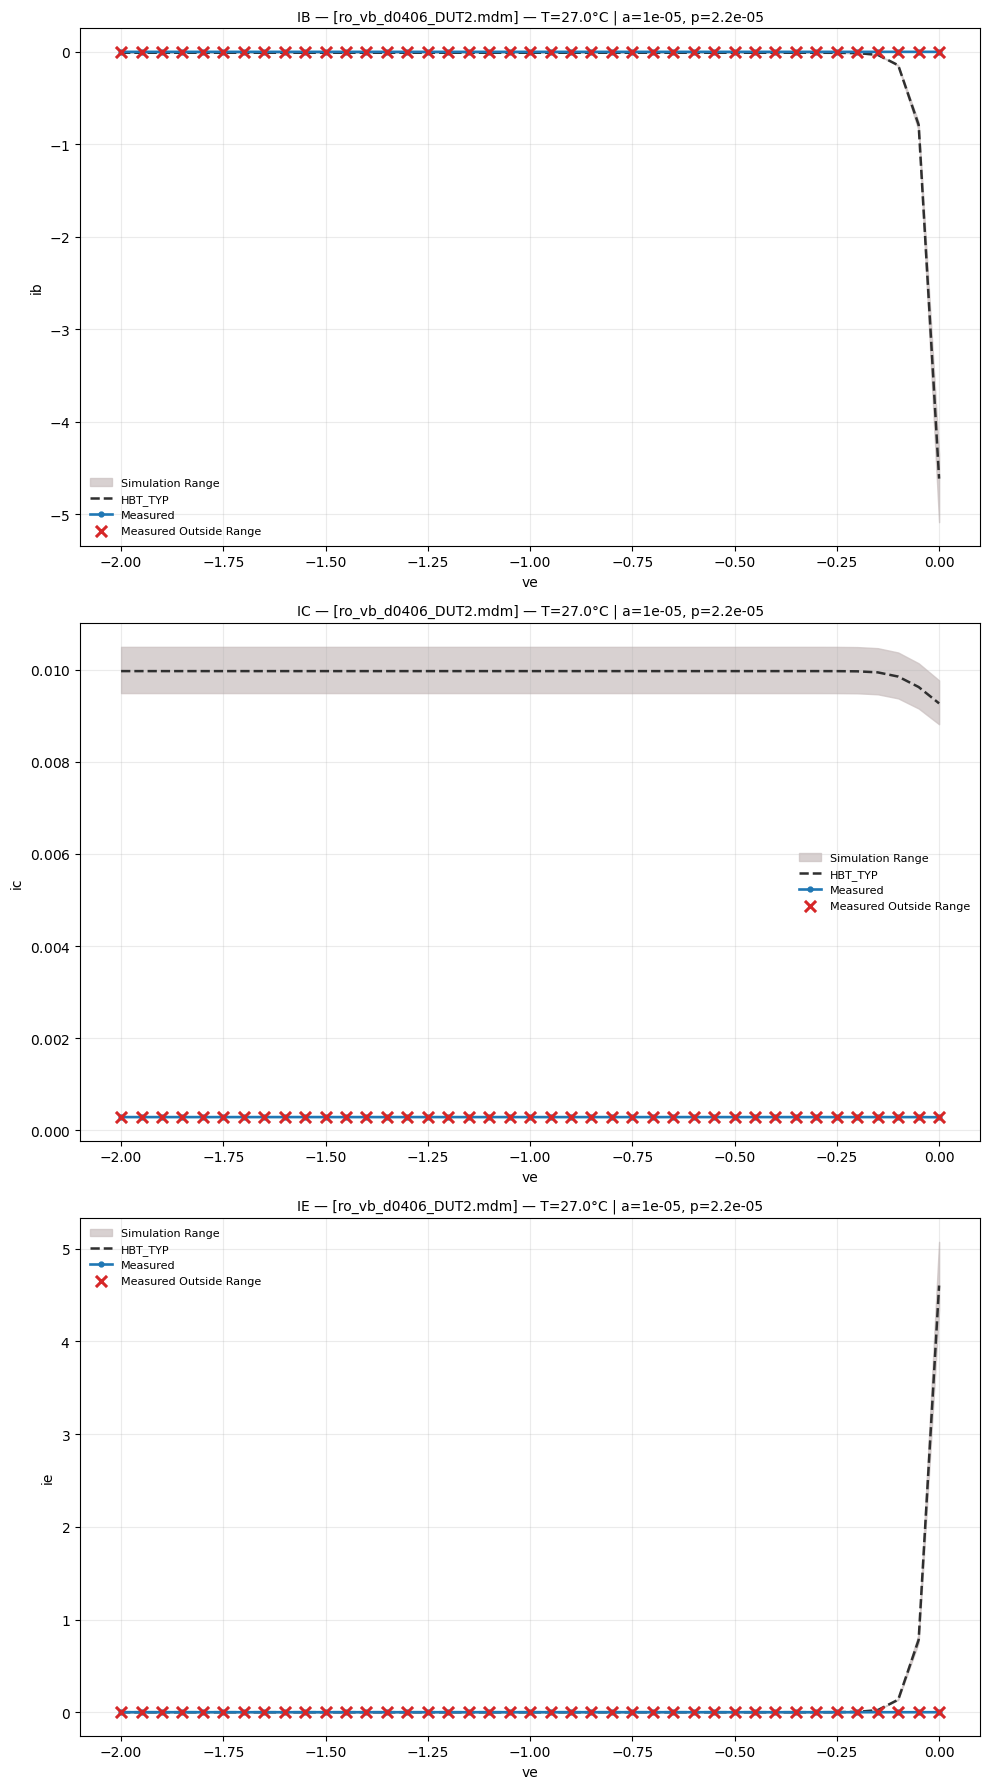

In [20]:

PANELS_PER_TYPE = 1   # how many panels per type
NCOLS           = 1   # grid columns

if "SIM_MERGED_BY_SETUP" not in globals() or not SIM_MERGED_BY_SETUP:
    print("[ERROR] No data loaded. Run a device first to populate Data.")
else:
    types = sorted(SIM_MERGED_BY_SETUP.keys())

    for t in types:
        print(f"\n=== {t} ===")
        plot_csv_type(t, panels=PANELS_PER_TYPE, ncols=NCOLS,)


In [ ]:
class EnhancedPlotWidget:
    def __init__(self):
        self.types_available = sorted(list(SIM_MERGED_BY_SETUP.keys())) if "SIM_MERGED_BY_SETUP" in globals() else []

        self.type_dd = Dropdown(options=self.types_available, description="Setup:")
        self.count_in = BoundedIntText(value=20, min=1, max=500, description="Max Panels:")
        self.cols_in = BoundedIntText(value=1, min=1, max=8, description="Grid Cols:")
        self.type_dd.observe(self._on_type_change, names='value')

        self.param_filters = {}

        self.plot_btn = Button(description="Generate Plot", button_style="primary")

        self.output = Output()
        self.param_filter_container = VBox()

        self.type_dd.observe(self._on_type_change, names='value')
        self.plot_btn.on_click(self._generate_plot)

        if self.types_available:
            self.type_dd.value = self.types_available[0]
            self._create_filters()
    def _on_type_change(self, change):
        """Callback to recreate filters when the Setup changes."""
        self._create_filters()

    def _format_dropdown_options(self, values):
        """Formats numeric values for the dropdown."""
        formatted_options = []
        for val in values:
            s = float(f"{float(val):.12g}")
            formatted_options.append((str(s), s))
        return formatted_options

    def _on_type_change(self, change):
        """Callback to recreate filters when the Setup changes."""
        self._create_filters()

    def _get_device_param_columns(self, device_type_hint):
        """Helper to get the list of parameters for a given Setup."""
        device_param_map = {
            'mos': ['temp', 'w', 'l', 'ad', 'as', 'pd', 'ps', 'nf', 'm'],
            'pnpmpa': ['a'],
            'hbt': ['ve', 'vs', 'temp', 'l', 'w', 'm', 'nx'],
        }
        device_type_lower = device_type_hint.lower()
        if device_type_lower in device_param_map:
            return device_param_map[device_type_lower]
        for dev_type, params in device_param_map.items():
            if dev_type in device_type_lower:
                return params
        return []

    def _get_filtered_data(self):
        """
        Reads all selected filter values and applies them to the dataframe.
        This is called only when the plot button is clicked.
        """
        if not self.type_dd.value or self.type_dd.value not in SIM_MERGED_BY_SETUP:
            return pd.DataFrame()

        df = SIM_MERGED_BY_SETUP[self.type_dd.value].copy()

        all_widgets = self.param_filters
        for col, widget in all_widgets.items():
            if hasattr(widget, 'value') and widget.value != 'All':
                val = widget.value
                if col in df.columns:
                    print(f"Applying filter: {col} = {val}")
                    if pd.api.types.is_numeric_dtype(df[col]):
                        df = df[np.isclose(df[col], val)]
                    else:
                        df = df[df[col] == val]
        return df

    def _create_filters(self):
        """
        Creates all filter dropdowns once. Populates them with ALL possible values.
        No complicated update logic is needed anymore.
        """
        if not self.type_dd.value or self.type_dd.value not in SIM_MERGED_BY_SETUP:
            return
        df = SIM_MERGED_BY_SETUP[self.type_dd.value]
        if df.empty: return

        self.param_filters.clear()

        # Create Device Parameter Filters
        param_cols = self._get_device_param_columns(verifier.device_type)
        param_widgets = []
        for col in param_cols:
            if col in df.columns and df[col].nunique() > 1:
                unique_vals = sorted(df[col].dropna().unique())
                formatted_options = self._format_dropdown_options(unique_vals)
                widget = Dropdown(options=[('All', 'All')] + formatted_options, value='All', description=f'{col}:', layout={'width': '200px'})
                self.param_filters[col] = widget
                param_widgets.append(widget)


        self.param_filter_container.children = [HTML("<b>Device Parameters:</b>")] + [HBox(param_widgets[i:i+4]) for i in range(0, len(param_widgets), 4)]

    def _generate_plot(self, button=None):
        """The main function called by the 'Generate Plot' button."""
        plt.close('all')
        with self.output:
            self.output.clear_output()

            filtered_df = self._get_filtered_data()

            if filtered_df.empty:
                print("[INFO] No data remains after applying the selected filters. Please change your filter selection.")
                return

            original_count = len(SIM_MERGED_BY_SETUP[self.type_dd.value])
            print(f"Original data: {original_count} rows")
            print(f"After filtering: {len(filtered_df)} rows")

            block_ids = list(filtered_df["block_id"].unique())
            max_panels = min(len(block_ids), self.count_in.value)
            print(f"Plotting {max_panels} panels from {len(block_ids)} unique blocks...")

            try:
                fig, axes = plot_blocks_comparison(
                    df=filtered_df, device_type_hint=verifier.device_type,
                    block_ids=block_ids[:max_panels], ncols=self.cols_in.value,
                    max_blocks=max_panels)
                display(fig)
                print("Plot generated successfully!")
                plt.close(fig)
            except Exception as e:
                print(f"[ERROR] Failed to generate plot: {e}")

    def display(self):
        """Sets up and displays the final UI widget"""

        main_controls = VBox([
            Label(f"Select Setup for {verifier.device_type} and plot settings:"),
            HBox([self.type_dd, self.count_in, self.cols_in]),
        ])

        filters_section = VBox([ self.param_filter_container ])

        interface = VBox([
            HTML("<p>Select a Setup, apply filters using dropdowns, then generate plots.</p>"),
            main_controls,
            filters_section,
            HBox([self.plot_btn]),
            self.output
        ])

        return interface

enhanced_widget = EnhancedPlotWidget()
enhanced_widget.display()